# 1. Introduction

## 1.1 What are we doing?

We're doing a little interactive project to give you a better feel for how LIGO data analysis actually works.  In particular, we'll be doing **matched filtering** of some data, including the data from the historic first detection of gravitational waves, GW150914.

You can kind of think of LIGO as a really sensitive microphone, and the data that comes out is like a sound recording.  (Except, of course, that sound requires air, while gravitational waves travel through spacetime itself.)  In fact, if you go to the LIGO control room, they'll often play the data over speakers, because this is a really useful way of thinking about the data.  It even happens to be in the right range for human hearing.  So we'll be listening to LIGO data and gravitational waveforms.

One of the first things you'll discover about the data is that it's full of noise, so we'll need to deal with that noise to pull out our signal.  We'll start off with the simplest way to deal with noise, involving the Fourier transform, and find that it actually works well enough to let us hear the GW150914 signal.  But if we want to do real science, we'll need to do better, so we'll introduce some real LIGO data analysis, including matched filters.

## 1.2 What are we looking at?

This is a [Jupyter notebook](https://jupyter.org/) (formerly known as an [IPython notebook](http://ipython.org/notebook.html)).  It's connected to an actual python session, but it runs through a web browser, so we can format things nicely and give some explanations, and so you don't have to copy-and-paste all the instructions into a normal python session.  It's meant to look and work kind of like Mathematica, if you've ever used that before.  (And if you don't care for python, Jupyter also handles [Julia](http://nbviewer.ipython.org/url/jdj.mit.edu/~stevenj/IJulia%20Preview.ipynb), [R](https://github.com/IRkernel/IRkernel), [IDL](https://github.com/lstagner/idl_kernel), and numerous other languages.)

Each of the sections in gray with something like "`In[1]:`" in front of it is called a *cell* and contains code for you to run.  Run the code by placing your cursor in the cell, then pressing Shift+Enter.  

As a first example, we'll load some "modules".  Any time we use python, we'll usually want to use some modules, which are just containers for a bunch of pre-written code.  Run the following cell to load the modules we'll need.

In [1]:
# These are for plotting
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

# This is an important module whenever you use python for numerics
import numpy as np

# This lets us read LIGO's data file
import h5py

# We'll do some fancy signal processing, which is easier with this
import scipy.signal

# These are some nice interactive things we'll use in this notebook
from IPython.display import display, Audio, Latex
import ipywidgets as widgets

# These are some messy functions I've defined in another file (`utilities.py`)
from utilities import filter_and_plot, add_notch_filter, fade, plot_td_and_fd, notch_data, bandpass

# This just sets the default size of our plots
mpl.rcParams['figure.figsize'] = [14.0, 6.0]

You won't be expected to understand the python code (though if you do, that's great).  But you should run it, follow along with the explanations, and try to understand all the plots and sounds.

If you put your cursor in a text section and something weird happens, just hit Shift+Enter, and everything will be okay.

<br /><br />

# 2. Listening to gravitational waves

Here, we'll look at and listen to the "expected signal" from the merger of a black-hole binary like the one measured in GW150914.

In [2]:
# Load the raw NR data
nr_complex = np.loadtxt('Data/NR_GW150914.txt').view(dtype=complex)[:, 0]
nr = fade((np.exp(-1.9j*np.pi)*nr_complex).real)

# Set up the time and sampling-frequency information for this signal
sampling_rate = 4096.0 # Hz
dt = 1/sampling_rate
t = np.arange(len(nr)) / sampling_rate

# Now Fourier transform the data, and get the corresponding frequencies
nrtilde = dt * np.fft.rfft(nr)
frequencies = np.fft.rfftfreq(len(nr), dt)

We can plot the signal in both the time and frequency domains, and even play the signal over headphones.

***CAUTION:*** If you can hear the long, deep inspiral at the beginning of the signal, then the merger may be very loud.  Be prepared to take your headphones away from your ears, or to turn down the volume, around the 16 second mark.

Contrast: 11.2105


<IPython.core.display.Javascript object>


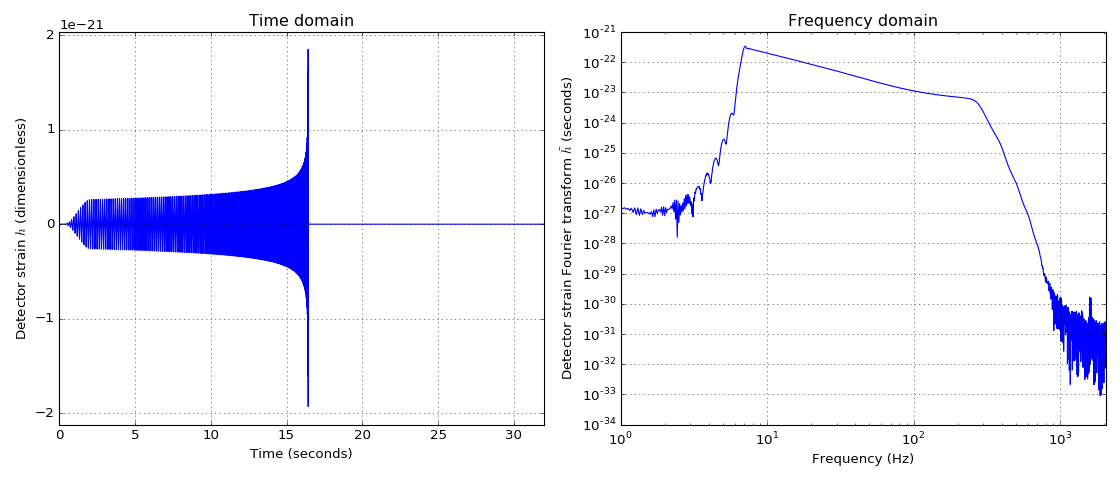

In [3]:
fig, (ax1, ax2) = plot_td_and_fd(t, nr, frequencies, nrtilde);

We notice a few important features in the time domain:

  - The amplitude is shut off entirely at the beginning, but quickly turns on.  This is done for technical reasons (to get rid of the so-called Gibbs phenomenon -- but don't worry about it).  Of course, a real gravitational-wave signal would extend fairly regularly very far back in time.
  - The amplitude is slowly growing at first, but accelerates to a peak, and then basically shuts off again.  This part is real.  That's the merger and ringdown, where the black holes give off the strongest gravitational waves just as they fall into each other, which happens very suddenly.
  - The frequency is slowly increasing at first, but accelerates up to the merger.  This is another effect of the inspiral; as energy is given off in gravitational waves, the black holes spiral inwards toward each other and go faster and faster.
  
These translate to some interesting features in the frequency domain:

  - The amplitude at low frequencies is shut off.  This is for the same reason as the time-domain signal: we just don't have a long enough signal to reach those low frequencies.  A real signal would keep going in a straight line off to the upper left.
  - Whereas the amplitude of the time-domain waveform *increases* as the frequency increases, the amplitude of the Fourier transform *decreases* as the frequency increases.
  - Around $250\, \mathrm{Hz}$, the amplitude drops off very suddenly.  This dropoff represents the merger.
  
## Questions
  * Can you hear any of the features that you see in the plots?
  * Why does the amplitude of the Fourier transform *decrease* as the frequency increases?
  * Why does it sound so quiet at the beginning and loud at the highest frequency?

The LIGO collaboration claimed that this signal (or one very much like it) is found in their detector data from September 14, 2015.  We have that data, and we can look for the signal ourselves.

<br /><br />

# 3. Listening to detector data

First, we'll load the data.  The following cell will give us the actual raw data that came out of the detector in Hanford, Washington.

In [4]:
# Load the raw data from LIGO Hanford
with h5py.File('Data/H-H1_LOSC_4_V1-1126259446-32.hdf5') as f:
    h = f['strain/Strain'][:]  # Time of event is 16.4

# We always want this to turn and off slowly:
h = fade(h)

We now have a data set named `h`, which represents the strain measured by the detector.  We also want to know the times associated with each data point, and a few useful features of that data set:

In [5]:
# Now Fourier transform the data, and get the corresponding frequencies
htilde = dt * np.fft.rfft(h)
frequencies = np.fft.rfftfreq(len(h), dt)

Now, we're ready to look at and listen to the raw data containing the GW150914 event.  First we'll plot the data as a function of time, then we'll plot (the magnitude of) the Fourier transform as a function of frequency.  Finally, we'll also be able to listen to the signal.  Remember to be careful of the volume.

Contrast: 3.6280


<IPython.core.display.Javascript object>


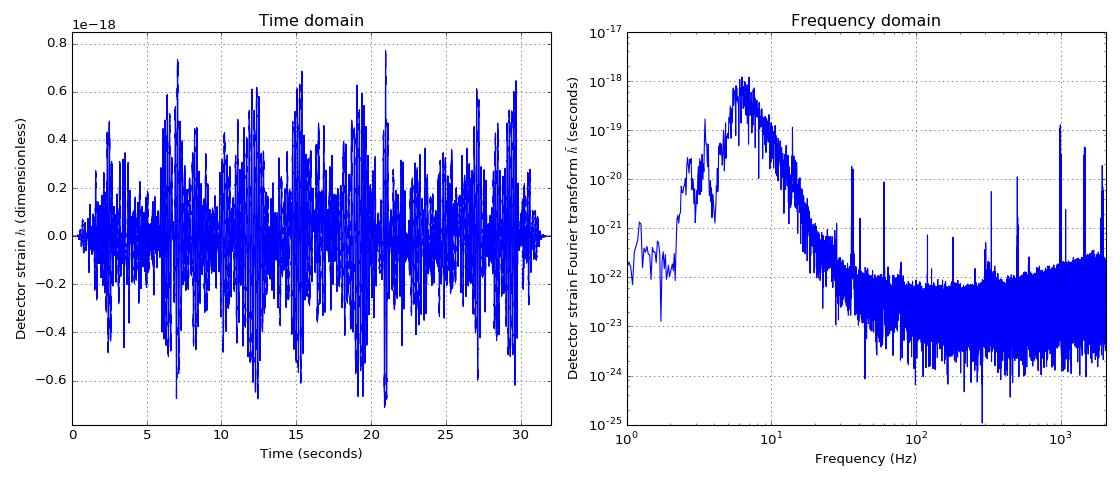

In [6]:
plot_td_and_fd(t, h, frequencies, htilde);

There are controls below the plots that let you zoom in and pan around on the plots.  Take a moment to explore the plots and think about these questions:


## Questions
  * What happened?  Why is this signal nothing at all like the pure gravitational wave we saw above?
  * Can you find the signal in the plots?
  * Can you hear the signal?
  * What are the sources of noise here?
  * The raw data sounds generally pretty high-pitched.  But looking in the frequency domain, we see that most of the signal is at very low frequencies.  Why doesn't the raw data sound low-pitched?


<br /><br />

# 4. Digging signal out of noise manually

LIGO has a lot of noise.  This is entirely expected when dealing with such a sensitive apparatus, but it does swamp the signal.  The key to LIGO's success is that the noise is pretty steady (or technically, "stationary"), and the noise is largest at frequencies that aren't the most interesting.  We can recover the interesting part of the signal by decreasing the size of the noise.  We will do this using a "graphic equalizer".

A graphic equalizer divides the signal into frequency bands, adjust the volume in each band, and then combines the signal back into a time-domain signal.  You may have seen graphic equalizers in old or high-end stereos:

<img src="70sEqualizer.jpg" width=640 title="Apparently, this and an eight-track of the Eagles' greatest hits were considered cool in the '70s..."
 alt="Creative Commons license via https://www.youtube.com/watch?v=ez6agxLfEeM">

Nowadays, you might see "bass" and "treble" (and maybe even "mid") controls, which do the same thing, but break the signal down into fewer frequency bands.

We're going to do the same thing, but without the old-timey hardware.  The cell below sets up a graphic equalizer, then produces the "equalized" data for you to look at and listen to.  Mess around with the settings, then press "Recalculate" to see how well you can pick out the signal we're looking for.



[comment]: <> (from utilities import filter_cheat)
[comment]: <> (filter_cheat(frequency_bin_upper_ends, sliders, notch_filters, gap_filler))



In [7]:
from utilities import filter_cheat

Contrast: 9.7157


<IPython.core.display.Javascript object>


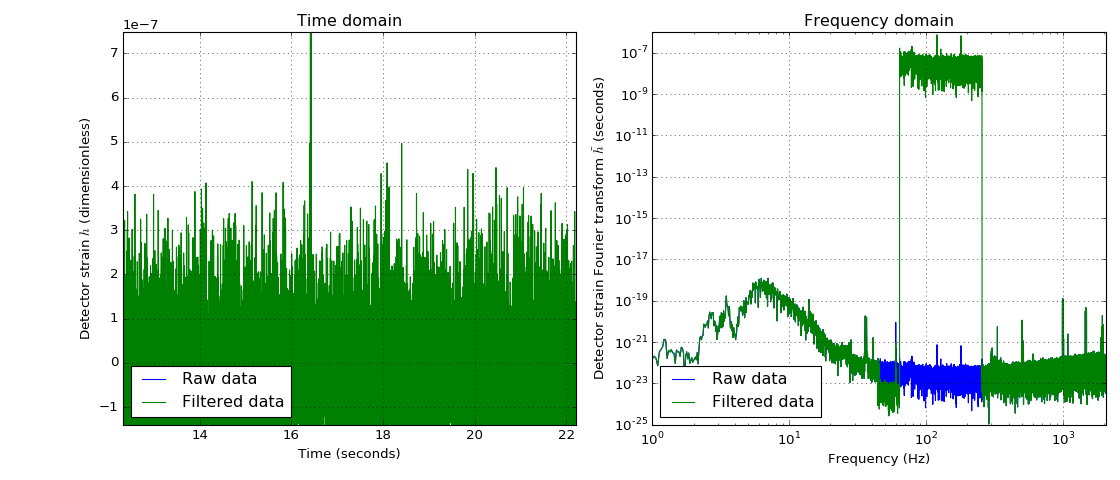

In [9]:
# Set up the frequency bins we'll use for our graphic equalizer
log2_sampling_rate = int(np.log2(sampling_rate/2))
frequency_bin_upper_ends = np.logspace(3, log2_sampling_rate, num=2*(log2_sampling_rate-3)+1, base=2)

# This is some code to set up some interactive sliders for our graphic equalizer
gap_filler = widgets.Label("", layout=widgets.Layout(flex='1 1 auto'))
separator = widgets.VBox([], border='1px solid #ccc', width='0px')
use_equalizer = widgets.Checkbox(description='Use equalizer', value=True)
labels = widgets.VBox([widgets.Label("Frequency (Hz)"), gap_filler, use_equalizer, gap_filler, widgets.Label("Amplitude (dB)")], width='110px')
sliders = [widgets.FloatSlider(min=-15.0, max=15.0, step=0.5, value=0.0, height='auto', readout_format='+.1f',
                               orientation='vertical', padding=6, description=str(int(freq)))
           for freq in frequency_bin_upper_ends]
equalizer = widgets.HBox(children=[labels, separator]+sliders+[separator], height='200px')
display(equalizer)

# We might also want to add specific little "notch" filters to get rid of noise sources like the 60 Hz hum from the power lines
notch_filters = widgets.VBox([], width='450px')
add_notch_filters = widgets.Button(description="Add notch filter")
add_notch_filters.on_click(lambda change: add_notch_filter(notch_filters, gap_filler))
display(add_notch_filters)
display(notch_filters)

# It sometimes gets confusing to see the original data plotted behind the filtered data, so add a checkmark to remove it
hide_original_time_domain = widgets.Checkbox(description='Hide raw t. d. data', value=False)

# Add a button to re-make the plot and audio for the current settings
recalculate_button = widgets.Button(description='Recalculate')
recalculate_button.on_click(lambda change: filter_and_plot(h, t, htilde, sampling_rate, sliders, notch_filters, use_equalizer, frequencies,
                                                           frequency_bin_upper_ends, hide_original_time_domain))
recalculate = widgets.HBox([recalculate_button, hide_original_time_domain])
display(recalculate)


filter_and_plot(h, t, htilde, sampling_rate, sliders, notch_filters, use_equalizer, frequencies,
                frequency_bin_upper_ends, hide_original_time_domain)

Spend some time playing around with the equalizer to pull out the signal.  (Hint: the low and high frequencies are where most of the noise is, and where less of the signal is.)

You can also add some notch filters to eliminate sharp spikes in the frequency-domain data, if you think they're more like noise than signal.  A notch filter is like another equalizer slider, except that you get to control where its frequency band begins and ends, and it sets everything in that band as low as it can go.

The signal you're looking for peaks near the middle of the data (around $t=16.4\, \mathrm{sec}$).


## Questions
  * Can you adjust the filters so that you can see the peak amplitude in the time domain?  What does it look like when you zoom in?  Can you hear it?
  * If you leave the $45\,\mathrm{Hz}$ band in the data, you see (and hear) big slow oscillations in the time-domain amplitude that are *much* slower than $45\,\mathrm{Hz}$.  Can you explain where these come from, and why they oscillate like that?
  * How does the largest data point of your filtered data (in the time domain) compare to the largest point in the raw data?  Why is this?
  * With good settings, you should be able to see a large spike right in the middle of the data.  But there are other spikes, too.  How is the middle spike different from the others?
[comment]: <> (    * Made up of three or four clustered spikes)
[comment]: <> (    * Get bigger and closer as time goes on, then drop suddenly)
[comment]: <> (    * That's a signature of gravitational waves from a merging black-hole binary)
  * If you zoom in on the plot of the filtered data, there's just a small amount that looks like it might contain the actual signal.  About how much time would you say this lasts for?  Roughly how many cycles of data would you believe come from the GW150914 event, as opposed to noise?
  * How could we improve the crude filtering we've done here?
[comment]: <> (    * Smoother filters)
[comment]: <> (    * More frequency bins)
[comment]: <> (    * Adjust equalizer proportionally to noise)
[comment]: <> (    * Adjust equalizer proportionally to an expected signal)
[comment]: <> (    * Use phase information of expected signal)

<br /><br />
# 5. Digging signal out of noise automatically

There are several ways we could improve the crude filtering we did above with our "equalizer".  We'll try two improvements in this section, and more in the following sections.

First, we could throw in more sliders to adjust for more precise equalization.  In fact, the only natural number of sliders is one for every frequency bin in the Fourier transform.  But there are already so many sliders for us to adjust that it gets tiring; we'd never be able to manually adjust them all.  Plus, we want something automatic that will work in every case.  Second, therefore, we can adjust the sliders automatically.  Roughly speaking, at frequencies with a lot of noise, we want to filter out a lot of the signal; at frequencies with little noise, we don't want to filter much.

The first step is to measure the noise as a function of frequency.  We already know that the signal is very small during most of our data, so we could define the noise at a particular frequency to just be the magnitude of the Fourier transform of the data.  But noise is random, and we've only taken a small sample of this random process, so we'd like to average the spectrum.  It turns out that a good way to do this is to split the data into chunks, measure the noise in each chunk, and then average the results — or more precisely the root mean square (RMS).  There are some additional tricks to deal smooth out the splitting process, and make sure we use all the data without overcounting some, etc.  All these tricks are dealt with in what is called "Welch's method".

In [ ]:
# Set how many chunks we want to split up the data into.  We want to balance the need
# for resolving sharp features in the noise (which would suggest using a small number)
# against averaging enough to reduce the variance (which suggests using a large number).
number_of_chunks = 8

# We want our chunks to have sizes that are powers of 2, which speeds up the Fourier
# transforms involved, but we also want about the right number of chunks.  This line
# gives us both, because `int` rounds to the nearest integer.
points_per_chunk = 2**int(np.log2(len(h)/number_of_chunks))

# Now, we can use Welch's method to automatically estimate the noise spectral density.
# The shenanigans we pull with log2 ensures that the chunks are sized to be a power
# of 2, which speeds up the Fourier transforms involved, but also gives us
# approximately the right number of chunks.
f_noise, noise_welch = scipy.signal.welch(h, sampling_rate, nperseg=points_per_chunk)

# Now we just deal with a little normalization weirdness to define the noise spectral density
noise_spectral_density = np.sqrt(2 * len(h) * noise_welch / sampling_rate)

# We'll also need to interpolate onto a finer set of frequencies
noise_spectral_density_interpolator = scipy.interpolate.InterpolatedUnivariateSpline(f_noise, noise_spectral_density)

We can compare our raw data to the estimated noise spectrum:

In [ ]:
plt.close()
plt.loglog(frequencies, np.abs(htilde), label='Raw data')
plt.loglog(f_noise, noise_spectral_density, label='Noise estimate')
plt.xlim(1, 0.6*sampling_rate)
plt.xlabel('Frequency (Hertz)')
plt.ylabel('Noise spectrum and strain Fourier transform (seconds)')
plt.grid()
plt.legend();

If you zoom in, you can see that our estimated noise spectrum is substantially smoother than the raw data, as we hoped.  It also emphasizes spikes because we used the RMS instead of just the simple mean.

So now that we've estimated the noise, we can use it to automatically "equalize" the raw data.  Remember that where the noise is large we want a lot of filtering, and where the noise is small we want little filtering.  So we just divide the raw data by the noise estimate:

In [ ]:
# We simply divide htilde by the noise estimate to "equalize" the data in the frequency domain
htilde_equalized = htilde / noise_spectral_density_interpolator(frequencies)

# Now we transform back to the time domain, and smoothly fade on and off to get rid of any loud clicks
h_equalized = fade(sampling_rate * np.fft.irfft(htilde_equalized))

# Finally we can plot and listen to the data
plot_td_and_fd(t, h_equalized, frequencies, htilde_equalized, h=h, htilde=1e21*htilde);

Unfortunately, this isn't nearly as good as what we could achieve manually using the graphic equalizer above.  If you zoom in, you might be able to convince yourself that the signal is there, and you should be able to hear a little blip at the right time.  But unless you knew it was there, you'd have a hard time convincing yourself.  Looking at the frequency-domain plot, we see why: There's still a lot of noise at the very high and low frequencies that are much smaller, but not gone.  Also, the spikes have not entirely gone away.  If you look back at our noise estimate around those spikes, you see that the estimate smears them out.  So evidently our way of estimating the noise is not good for very sharp features.

We can solve each of these problems, however.  We'll solve the first by removing the high- and low-frequency components even more than the "equalization" did.  We'll solve the second by removing those lines with notch filters before "equalizing" the data.

The first step is to create notch filters for the spikes we see in the input spectrum.  This time, we'll do a slightly better job using smooth notches, instead of the sharp square notches we used above.  Here we list each notch (beginning and ending frequencies) and something related to the depth of the notch.  This may not seem very automatic, but these spikes are fairly constant, so we can just list them once and use the same list forever.

In [ ]:
notch_locations_and_sizes = [(35.1, 37.1, 0.25), (35.7, 36., 0.8), (36.6, 36.8, 1.3), (40.9, 41.0, 2), (77.4, 79.7, 0.2),  # Gremlins
                             (59.9, 60.1, 4), (119.9, 120.1, 3), (179.9, 180.1, 4),  # Line noise
                             (299.47, 299.7, 2), (303.2, 303.35, 2), (310., 327., 0.25), (331.7, 332.2, 2), # Violin modes
                             (500.5, 503.1, 1.0), (504.7, 504.9, 1.5), (507.0, 508.7, 1.5), # Violin modes
                             (991.2, 992.8, 4), (993.7, 997.0, 4), (997.5, 999.5, 4), (1003.7, 1005.4, 4)  # Violin mode harmonics
                            ]

h_notched = fade(notch_data(h, sampling_rate, notch_locations_and_sizes))
#h_notched = fade(notch_data(h, sampling_rate, notch_locations_and_sizes))
htilde_notched = dt * np.fft.rfft(h_notched)

# Finally we can plot and listen to the notched data
plot_td_and_fd(t, h_notched, frequencies, htilde_notched, htilde=dt*np.fft.rfft(fade(h)));

Those spikes have gone away pretty nicely, but this is almost the same as the raw data.  So we try again to auto-equalize:

In [ ]:
# Now we'll estimate the noise spectrum again
number_of_chunks = 8
points_per_chunk = 2**int(np.log2(len(h_notched)/number_of_chunks))
f_noise, noise_welch = scipy.signal.welch(h_notched, sampling_rate, nperseg=points_per_chunk)
noise_spectral_density = np.sqrt(2 * len(h_notched) * noise_welch / sampling_rate)
noise_spectral_density_interpolator = scipy.interpolate.InterpolatedUnivariateSpline(f_noise, noise_spectral_density)

# And we'll filter the data using this new estimate
htilde_notched_equalized = htilde_notched / noise_spectral_density_interpolator(frequencies)
h_notched_equalized = fade(sampling_rate * np.fft.irfft(htilde_notched_equalized))

plot_td_and_fd(t, h_notched_equalized, frequencies, htilde_notched_equalized, htilde=1e21*htilde);

We're starting to see the signal a little more clearly, and there are no big spikes in the frequency domain, suggesting that we've done a pretty good job of filtering.  The final step is to simply cut off the low frequencies where the noise swamped the signal, and the high frequencies where we don't expect any signal at all.

In [ ]:
h_filtered = bandpass(h_notched_equalized, sampling_rate, lower_end=35.0, upper_end=250.0)
h_filtered_tilde = dt * np.fft.rfft(h_filtered)

plot_td_and_fd(t, h_filtered, frequencies, h_filtered_tilde, htilde=1e22*htilde);

Finally, we've gotten a pretty clear signal.  It stands out more than anything you could *credibly* achieve by hand with the graphic equalizer.  It follows the noise curve reasonably well in the most sensitive band, except for those spikes that we know are just noise.  And it falls off very quickly outside of the sensitive band.

Most importantly, we've cleaned up this signal without any tweaking that might apply only to this system.  In fact, we can make a function that encapsulates everything we've done and returns the filtered signal, and then apply that function to a different signal and still get a nice result.

In [ ]:
def filter_signal(raw_signal, sampling_rate, upper_bandpass_frequency=250.0):
    import numpy as np
    from scipy.interpolate import InterpolatedUnivariateSpline
    from scipy.signal import welch
    from utilities import fade, notch_data, bandpass
    
    # First, we fade in at the beginning and out at the end
    filtered_signal = fade(raw_signal)
    frequencies = np.fft.rfftfreq(len(filtered_signal), d=1/sampling_rate)

    # We defined these before, outside this function, but we can do it again to make sure they didn't get changed
    notch_locations_and_sizes = [(35.1, 37.1, 0.25), (35.7, 36., 0.8), (36.6, 36.8, 1.3), (40.9, 41.0, 2), (77.4, 79.7, 0.2),  # Gremlins
                             (59.9, 60.1, 4), (119.9, 120.1, 3), (179.9, 180.1, 4),  # Line noise
                             (299.47, 299.7, 2), (303.2, 303.35, 2), (310., 327., 0.25), (331.7, 332.2, 2), # Violin modes
                             (500.5, 503.1, 1.0), (504.7, 504.9, 1.5), (507.0, 508.7, 1.5), # Violin modes
                             (991.2, 992.8, 4), (993.7, 997.0, 4), (997.5, 999.5, 4), (1003.7, 1005.4, 4)  # Violin mode harmonics
                            ]
    
    # Now we notch the data and make sure it's still faded
    filtered_signal = fade(notch_data(filtered_signal, sampling_rate, notch_locations_and_sizes))
    
    # Estimate the noise spectrum
    number_of_chunks = 8
    points_per_chunk = 2**int(np.log2(len(filtered_signal)/number_of_chunks))
    f_noise, noise_welch = welch(filtered_signal, sampling_rate, nperseg=points_per_chunk)
    noise_spectral_density = np.sqrt(2 * len(filtered_signal) * noise_welch / sampling_rate)
    noise_spectral_density_interpolator = InterpolatedUnivariateSpline(f_noise, noise_spectral_density)

    # Equalize the data using this noise estimate
    filtered_signal_tilde = np.fft.rfft(filtered_signal) / sampling_rate
    filtered_signal_tilde = filtered_signal_tilde / noise_spectral_density_interpolator(frequencies)
    filtered_signal = fade(sampling_rate * np.fft.irfft(filtered_signal_tilde))
    
    # Finally, bandpass the equalized notched data
    filtered_signal = bandpass(filtered_signal, sampling_rate, lower_end=35.0, upper_end=upper_bandpass_frequency)
    
    return filtered_signal

The cell above defines the function.  Now we'll load the data from LIGO Livingston, and filter it.

In [ ]:
# Load the raw data from LIGO Livingston
with h5py.File('Data/L-L1_LOSC_4_V1-1126259446-32.hdf5') as f:
    l = f['strain/Strain'][:]  # Time of event is 16.4

# Now Fourier transform the raw data
ltilde = dt * np.fft.rfft(l)

# Filter it using our function
l_filtered = filter_signal(l, sampling_rate)

# Now Fourier transform the filtered data
l_filtered_tilde = dt * np.fft.rfft(l_filtered)

# Finally plot and play it
plot_td_and_fd(t, l_filtered, frequencies, l_filtered_tilde, h=l, htilde=1e22*ltilde);

The Livingston data is a little quieter because of how the detectors were pointed, so the peak isn't as far above the noise as it was with Hanford data, but it's still pretty clear.  The noise curve looks a little different, but our filtering is still similar enough that it works nicely.

We can plot the two of them together to see how close they are.  We need to flip the sign of one of the signals because the two detectors are rotated with respect to each other, and we have to shift Livingston's data $7.2\, \mathrm{ms}$ forward in time because that's how long it took the gravitational waves to travel from one detector to the other.

In [ ]:
plt.close()
plt.plot(t+0.0072, -l_filtered, label='Livingston')
plt.plot(t, h_filtered, label='Hanford')
plt.xlim(16.2, 16.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Detector strain $h$ (dimensionless)')
plt.title('Filtered detector data from the GW150914 event')
plt.grid()
plt.legend();

# Here, we'll play the sounds with Livingston in the left ear and Hanford in the right
display(Audio(data=np.vstack((np.roll(-l_filtered, int(0.0072*sampling_rate)), h_filtered)), rate=sampling_rate))

These are two pretty large signals.  They also match each other really nicely, and they arrived at different places on the earth close in time to each other.  Taken together, this already argues pretty strongly that these are gravitational waves.  In fact, the LIGO collaboration's analysis of their data suggest that — without any black holes — a coincidence like this would only happen no more than once in every 8400 years of data.  Considering that their analysis only covered 16 days of data, it's pretty unlikely to just be coincidence.  But that's a very crude way of looking at the data.

We can do much better if we try to fit this data with an analytical waveform.  In fact, we can use an expected signal to find gravitational waves in our data even when they're completely swamped by the noise and we have no chance of seeing or hearing them.  More than just *detecting* the waves, we'll also be able to *measure* the systems that generated them if we try lots of different "expected" signals and see which one matches best.

<br /><br />
# 6. Digging signal out of noise with a model waveform

We've really improved the signal just by filtering out what we suspect to be noise.  But most signals LIGO will see will be much smaller than this one.  And we need some more quantitative assessment than "Yeah, that sounds right."  We need to compare the data to a model.

If we have a model waveform from some numerical simulation, we can use that information to test if the model signal is present in the data.  The trick is to line the model up with where we think it is in the data, and then just multiply the model times the data at each point.  Places where the model is positive and the data is positive will stay positive; places where they are both negative will multiply to a positive.  So anywhere the model and the data are the same, we can expect to find a positive product.  Places where they are different will give us a negative product.  

If the product is more positive than negative for a lot of the time, we can say that our signal is probably present in the data.  If the signal isn't the same as the data, their product will just randomly wander back and forth between positive and negative.  So to make this more quantitative still, we can look at the average value of the product.  To make this all very simple, f our detector data is $d(t)$ and our simulated data is $s(t)$, we'll evaluate the correlation
\begin{equation}
  c = \int_T\ d(t)\, s(t)\, dt.
\end{equation}
If this is a large positive number, we have good evidence that $s$ is present in $d$.

[comment]: <> (So far, we've filtered the data based simply on what we think of the data itself, and our guesses about where noise might be.  We've adjusted the amplitude of the signal to be small where we expect noise to be large, and vice versa.  But if we have some "expected" signal that might be found in the data, we can use that information to filter more precisely, by turning down the amplitude where we don't expect to find much signal and turning it up where we do.  Previously, we divided by the amplitude of the noise; now, we'll multiply by the amplitude of the signal.)

First, though, we have to make sure that our model is lined up with the data and looks like it's found in the data.  We'll just plot the simulated signal right on top of the filtered detector data.

In [ ]:
plt.close()
plt.plot(t+0.0072, -l_filtered, label='Livingston')
plt.plot(t, h_filtered, label='Hanford')
plt.plot(t-0.002, 8e21*nr, label='Simulated')
plt.xlim(16.0, 16.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Detector strain $h$ (dimensionless)')
plt.title('Filtered detector data and simulated signal')
plt.grid()
plt.legend(loc='upper left');

# Here, we'll play the sounds with Livingston in the left ear, Hanford in the right, and NR in the center
# We "roll" the Livingston and simulated data as a simple way of shifting them in time
display(Audio(data=np.vstack((np.roll(-l_filtered, int(0.0072*sampling_rate)), h_filtered, np.roll(8e21*nr, int(-0.002*sampling_rate)))),
              rate=sampling_rate))

This looks fishy because early on, the simulated signal is quite large, but the detector data is clearly much smaller.  We might conclude that the data does not actually contain this signal.  However, we've done nothing to the simulated waveform, whereas we've applied very strong filtering to the detector data.  In particular, the noise gets large at low frequencies, so we've reduced the amplitude of the data there.  But early on, our simulated signal has power at low frequencies.  So if we want to see how the simulated data compare to the measured data, we should treat it the same: we need to filter the simulated waveform.

In [ ]:
# Filter and rescale arbitrarily to match amplitude of data
filtered_nr = 0.15 * filter_signal(nr, sampling_rate)

# Now, plot and play the *filtered* NR data on top of the filtered detector data
plt.close()
plt.plot(t+0.0072, -l_filtered, label='Livingston')
plt.plot(t, h_filtered, label='Hanford')
plt.plot(t-0.002, filtered_nr, label='Simulated and filtered')
plt.xlim(16.0, 16.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Detector strain $h$ (dimensionless)')
plt.title('Filtered detector data and simulated signal')
plt.grid()
plt.legend(loc='upper left');
display(Audio(data=np.vstack((np.roll(-l_filtered, int(0.0072*sampling_rate)), h_filtered, np.roll(filtered_nr, int(-0.002*sampling_rate)))),
              rate=sampling_rate))

Now this looks believable.  We still have a lot of noise in the detector data, but we can believe that our signal is basically added to that background noise.

So we can now try our trick of multiplying the detector data by the simulation data.

In [ ]:
l_correlation = np.roll(-l_filtered, int(0.0072*sampling_rate)) * np.roll(filtered_nr, int(-0.002*sampling_rate))
h_correlation = h_filtered * np.roll(filtered_nr, int(-0.002*sampling_rate))

# Integrate the correlation functions over time
c_l = scipy.integrate.simps(l_correlation, t)
c_h = scipy.integrate.simps(h_correlation, t)
display(Latex(r'$c_{{\mathrm{{Livingston}}}} = {0:.4f}$'.format(c_l)))
display(Latex(r'$c_{{\mathrm{{Hanford}}}} = {0:.4f}$'.format(c_h)))

# Plot the correlation functions as functions of time
plt.close()
plt.plot(t, l_correlation, label='Livingston')
plt.plot(t, h_correlation, label='Hanford')
plt.grid()
plt.xlim(16.25, 16.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Correlation between data and simulated signal')
plt.legend();

We see that we really do see lots of positive numbers right around the merger, and relatively few negative numbers.  This is very unlikely to happen just by chance.

## Questions

  * What happens if you shift the simulated signal by a few seconds, so that it's not a good model for the detector data?
  * What does the correlation look like as a function of time if you have the wrong shift, and how does it compare to the correlation when you have the right time offset?
  * What about the integral of the correlation?
  * Do these numbers seem a little arbitrary to you?  What happens if the source is twice as close, so the amplitude is twice as large?  Can you normalize our correlation quantity so that it never gets bigger than $1$?  (That way, you can compare the correlations using different simulated waveforms without worrying about their scale.)

<br /><br />

# 7. Speeding up the process for LIGO searches

LIGO searches for signals by evaluating the correlation for huge numbers of possible systems, using huge numbers of "simulated" waveforms.  This is a very computationally expensive problem.  But one thing that makes it even worse is that we don't know when a binary might be merging out in the universe, so we have to shift the simulated waveform around to find the best correlation.  If we had to multiply the waveforms and integrate for every possible time offset, LIGO would never be able to work quickly enough to actually find a system.  But we can do better with some clever math tricks.

The [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) tells us that the product $g(t)\, h(t)$ is equal to the inverse Fourier transform of the convolution of the Fourier transforms:
\begin{align}
  g(t)\, h(t)
  &= \int_{-\infty}^{\infty}\ \left[\int_{-\infty}^{\infty}\ \tilde{g}(f')\, \tilde{h}(f-f')\, df'\right]\, e^{2\pi i f t}\, df, \\
  &= \int_{-\infty}^{\infty}\ \left[\int_{-\infty}^{\infty}\ \tilde{g}(f')\, \tilde{h}^\ast(f'-f)\, df'\right]\, e^{2\pi i f t}\, df.
\end{align}
In the second line, we use the fact that our signals are real, so $\tilde{h}(f-f') = \tilde{h}^\ast(f'-f)$.  Now, if we integrate both sides over $t$, we can exchange the order of integrations and use a formula for the [Dirac $\delta$ function](https://en.wikipedia.org/wiki/Dirac_delta_function) to eliminate the integrals over $t$ and $f$, so we're left with
\begin{equation}
  \tag{1}
  \int_{-\infty}^{\infty}\ g(t)\, h(t)\, dt = \int_{-\infty}^{\infty}\ \tilde{g}(f')\, \tilde{h}^\ast(f')\, df'.
\end{equation}
That is, we can evaluate our correlation in the time domain or the frequency domain, as we see fit.

One thing that slows down this process is that we have to evaluate the correlation for every simulated waveform — even when we only change the time offset of the simulation.  Since we don't really know when any binary might be merging in the universe, we have to find the best correlation as we shift the simulated data by some $\delta t$.  It's not too hard to prove this fact about the Fourier transform: If $g(t) \mapsto \tilde{g}(f)$, then
\begin{equation}
  g(t + \delta t) \mapsto \tilde{g}(f)\, e^{2\pi\, i\, f\, \delta t}.
\end{equation}
So we can generalize the equation above to read
\begin{equation}
  \tag{2}
  \int_{-\infty}^{\infty}\ g(t + \delta t)\, h(t)\, dt = \int_{-\infty}^{\infty}\ \tilde{g}(f')\, \tilde{h}^\ast(f')\, e^{2\pi\, i\, f\, \delta t}\, df'.
\end{equation}
The right-hand side is just the inverse Fourier transform of $\tilde{g}(f')\, \tilde{h}^\ast(f')$, but this is easy and fast to compute!  In this case, the inverse Fourier transform is a function of $\delta t$, so we can compute it, and then just pick the largest value, and we've automatically optimized the time offset.

So far in this section, we've been assuming that both signals $g$ and $h$ are already "equalized" by the noise spectrum.  The squared noise spectrum is usually written $S_n(f)$.  Using this, we define the "match" between two not-yet-equalized signals to be
\begin{align}
  M(g, h)
  = \max_{\delta t}{}\ \int_{-\infty}^{\infty}\ g(t + \delta t)\, h(t)\, dt,
  = \max_{\delta t}{}\ \int_{-\infty}^{\infty}\ \frac{\tilde{g}(f)\, \tilde{h}^\ast(f)} {S_n(f)}\, e^{2\pi\, i\, f\, \delta t}\, df.
\end{align}
Finally, there's also a standard assumption that we've normalized $g$ and $h$ so that their matches with themselves are just $1$.  This is the actual formula that LIGO uses to run its searches.

## Questions

  * Can you derive the equation for the Fourier transform of a time-offset signal?
  * Can you derive the equation for the correlation in the frequency domain?
  * How can we normalize the input waveforms?

<br /><br />

# 8. The second detection

GW150914 was the first direct detection of gravitational waves.  And it was a nice one because it was so large you could hear it in the data with almost no help.  We expect that to be unusual.  For example, the second detection GW151226 is very hard (or maybe impossible) to see or hear.  But using the data analysis techniques we developed above, it's possible to show that there is indeed a signal buried in there.  See if you can do it.

First, we load the model waveform:

In [ ]:
# Load the raw NR data
nr_GW151226_complex = np.loadtxt('Data/NR_GW151226.txt').view(dtype=complex)[:, 0]
nr_GW151226 = fade((np.exp(0j*np.pi)*nr_GW151226_complex).real)

# Now Fourier transform the data, and get the corresponding frequencies
nr_GW151226_tilde = dt_GW151226 * np.fft.rfft(nr_GW151226)

Next we load the detector data:

In [ ]:
# Load the raw data; event peaks at 16.65 seconds
with h5py.File('Data/H-H1_LOSC_16_V1-1135136334-32.hdf5') as f:
    h_GW151226 = f['strain/Strain'][:]
h_GW151226 = fade(h_GW151226)
with h5py.File('Data/L-L1_LOSC_16_V1-1135136334-32.hdf5') as f:
    l_GW151226 = f['strain/Strain'][:]
l_GW151226 = fade(l_GW151226)

sampling_rate_GW151226 = 16384.0
dt_GW151226 = 1 / sampling_rate_GW151226
t_GW151226 = np.arange(len(h_GW151226)) / sampling_rate_GW151226
frequencies_GW151226 = np.fft.rfftfreq(len(h_GW151226), dt_GW151226)

# Now Fourier transform the raw data
h_GW151226_tilde = dt_GW151226 * np.fft.rfft(h_GW151226)
l_GW151226_tilde = dt_GW151226 * np.fft.rfft(l_GW151226)

# Filter it using our function
h_GW151226_filtered = filter_signal(h_GW151226, sampling_rate_GW151226)
l_GW151226_filtered = filter_signal(l_GW151226, sampling_rate_GW151226)

# Now Fourier transform the filtered data
h_GW151226_filtered_tilde = dt_GW151226 * np.fft.rfft(h_GW151226_filtered)
l_GW151226_filtered_tilde = dt_GW151226 * np.fft.rfft(l_GW151226_filtered)

# Finally plot and play it
plot_td_and_fd(t_GW151226, h_GW151226_filtered, frequencies_GW151226, h_GW151226_filtered_tilde, h=h_GW151226, htilde=1e22*h_GW151226_tilde);